# A Data-Driven Analysis of Football Player Performance and Wage

Olga Litvinova

**Football** is one of the most popular sports in the world, enjoyed by
billions of fans and generating huge amounts of money through TV rights,
sponsorship, and merchandise. Because of this, football players often
earn some of the highest salaries in professional sports. Clubs spend a
lot of money on players based on their skills, physical abilities, and
overall performance.

This project is divided into two major components:

1.  **EDA** - We will start with exploratory data analysis, and see the
    connection between player performance and salary to understand what
    factors influence how much footballers get paid.  
2.  **Regression model** - Then, we will use regression modeling to see
    how different performance metrics affect player wages, giving us
    insights into what really drives player value in football.For that
    we will apply Recursive Feature Elimination (RFE) and backward
    elimination from ML.

By the way, to ensure a consistent and meaningful analysis, we focus
exclusively on players from the **top 10 football leagues**. The league
rankings used in this analysis were sourced from [Football Flick’s Top
10
Leagues](https://footballflick.com/en-gr/blogs/news/the-best-leagues-in-the-world-top-10-ranked).

For the purposes of this study, **Turkey’s Süper Lig** was included in
place of **USA/Canada**.

Additionally, goalkeepers are excluded from the analysis because their
performance metrics differ significantly from those of outfield players,
and including them could introduce bias into the results.

## Data

The dataset used in this project was sourced from
[SoFIFA](https://sofifa.com/players?type=all&col=wg&sort=desc), a
platform that provides detailed information on football players from
various leagues worldwide. The data reflects player statistics as of
**the end of 2024**

The dataset includes the following key information:

-   **Personal Details:** Player name, age, preferred foot, height, and
    weight.  
-   **Club & Contract:** League, contract duration, release clauses.  
-   **Performance Metrics:** Technical skills (e.g., finishing,
    dribbling), physical attributes (e.g., sprint speed, stamina), and
    mental attributes (e.g., vision, composure).  
-   **Market Value:** Estimated player value and salary information.  
-   **Positional Data:** Best position and player role (attacker,
    midfielder, defender, goalkeeper).

In this analysis, goalkeepers have been excluded to ensure consistency
and accuracy when examining player performance, market value, and
salary. This decision was made because goalkeepers have unique
performance metrics (such as GK.Reflexes, GK.Diving, GK.Handling, and
GK.Positioning) that are not comparable to the metrics used for outfield
players, such as Finishing, Dribbling, Passing, and Sprint Speed.

### Data Manipulation

In [ ]:
league_rankings <- data.frame(
  League = c( "Süper Lig (Türkiye)", 
             "Eredivisie (Netherlands)","Primeira Liga (Portugal)","Liga Profesional de Fútbol (Argentina)", "Série A (Brazil)",  "Ligue 1 (France)",
             "Serie A (Italy)", "Bundesliga (Germany)", "La Liga (Spain)", "Premier League (England)"),
  League_Rank = 10:1  
)
numeric_vars <- c("Finishing", "Dribbling", "Shot.Power", "Sprint.Speed", 
                  "Attack.Position", "Short.Passing", "Vision", "Long.Passing", 
                  "Stamina", "Standing.Tackle", "Interceptions", "Strength", 
                  "Defensive.Awareness", "Heading.Accuracy", "Crossing","Overall.Score", 
                  "Potential.Score", "Composure", "Reactions","International.Reputation", "Aggression",
                  "Total.Movement", "Total.Power", "Total.Defending", "Total.Mentality", "Total.Stats" ,"Volleys","Curve","FK.Accuracy","Ball.Control", "Acceleration","Agility","Balance","Jumping" ,"Long.Shots", "Penalties","Sliding.tackle")


df_clean<- df %>% 
  left_join(league_rankings, by = "League") %>% 
  mutate(
    Wage = as.numeric(str_replace_all(str_remove_all(Wage, "€"), c("K" = "000", "M" = "000000"))),
    Value = as.numeric(str_replace_all(str_remove_all(Value, "€"), c("K" = "000", "M" = "000000"))),
    Contract.Start = as.numeric(Contract.Start),
    Contract.End = as.numeric(Contract.End),
    Contract.Duration=Contract.End-Contract.Start,
    Height_cm = as.numeric(str_extract(Height, "\\d+")),
    Weight_kg = as.numeric(str_extract(Weight, "\\d+")),
    Left_Foot = ifelse(Preferred.Foot == "Left", 1, 0),
    across(all_of(numeric_vars), 
                ~ as.numeric(str_remove(., "\\+\\d+"))),
    Role = case_when(
      #Option1
      str_detect(Best.Position, "LW|RW") ~ "Winger",
      str_detect(Best.Position, "ST|CF") ~ "Striker",
      str_detect(Best.Position, "CM|CAM|CDM") ~ "Central Midfielder",
      str_detect(Best.Position, "CB") ~ "Central Defender",
      str_detect(Best.Position, "RWB|LWB|LB|RB") ~ "Side Defender",
      str_detect(Best.Position, "LM|RM") ~ "Side Midfielder",
      #Option2
        # str_detect(Best.Position, "ST|CF|LW|RW|CAM") ~ "Offensive Playmaker",
        # str_detect(Best.Position, "CM|CDM|LM|RM") ~ "Link Player",
        # str_detect(Best.Position, "CB|LB|RB|RWB|LWB") ~ "Defensive Anchor",
      #Option3
        # str_detect(Best.Position, "ST|CF") ~ "High-Value Striker",
        # str_detect(Best.Position, "LW|RW|CAM") ~ "Creative Forward",
        # str_detect(Best.Position, "CM|CDM") ~ "Engine Room Midfielder",
        # str_detect(Best.Position, "CB") ~ "Defensive Leader",
        # str_detect(Best.Position, "LB|RB|RWB|LWB") ~ "Modern Full-Back",

      TRUE ~ "Unknown"  
  ),
  LeagueRanked = paste0("#", League_Rank, " ", League)
  ) %>%
  filter(Role != "Unknown", !is.na(Overall.Score), !is.na(Wage),   !is.na(Contract.Duration), League %in% league_rankings$League, Best.Position != "GK")%>%
    select(
    -c(Position, Player.ID, Loan.End, Attacking.Work.Rate, Defensive.Work.Rate, 
       Source_File, Joined.Team, Height, Weight, Real.Face, Body.Type, 
       Contract.Start, Contract.End, Total.Goalkeeping,Preferred.Foot,Best.Overall,Release.Clause, Weak.Foot,Best.Position),
    -matches("^(GK\\.|Total\\.)")
  )
  
#Calculate median overall and potential scores across all players
median_overall <- df_clean %>%
  summarise(median_value = median(Overall.Score, na.rm = TRUE)) %>%
  pull(median_value)  # Converts it to a vector

median_potential <- df_clean %>%
  summarise(median_value = median(Potential.Score, na.rm = TRUE)) %>%
  pull(median_value)


#Assign performance categories, calculating the share of each category per League
df_clean<-df_clean %>% mutate( 'Performance Category' = case_when(
      Overall.Score >= median_overall & Potential.Score >=median_potential ~ "Emerging High Performers",  # "High Overall, High Potential"
      Overall.Score >= median_overall & Potential.Score < median_potential ~ "High Peak Performers", # "High Overall, Low Potential"
      Overall.Score < median_overall & Potential.Score >= median_potential ~ "Future High Performers", #  "Low Overall, High Potential"
      Overall.Score < median_overall & Potential.Score < median_potential ~ "Limited Performance" # "Low Overall, Low Potential"
    )) %>%
  group_by(LeagueRanked) %>%
  mutate(Total_Count = n()) %>%
  
  group_by(LeagueRanked, `Performance Category`) %>%
  mutate(Count = n()) %>% 
  
   mutate(Percentage = round((Count / Total_Count) * 100, 0)) %>%
  group_by(LeagueRanked) %>%
  mutate(
    x_pos = case_when(
      `Performance Category` %in% c("Emerging High Performers", "High Peak Performers") ~ 90,
      `Performance Category` %in% c("Future High Performers", "Limited Performance") ~ 50
    ),
    y_pos = case_when(
      `Performance Category` %in% c("Emerging High Performers", "Future High Performers") ~ 90,
      `Performance Category` %in% c("High Peak Performers", "Limited Performance") ~ 60
    )
  ) %>%
  
  ungroup()

avg_wage_per_league <- df_clean %>%
  group_by(LeagueRanked,League_Rank) %>%
  summarise(Average_Wage = mean(Wage, na.rm = TRUE) / 1000) 

head(df_clean)

# A tibble: 6 × 59
  Player         League   Age Overall.Score Potential.Score Growth  Value   Wage
  <chr>          <chr>  <int>         <dbl>           <dbl>  <int>  <dbl>  <dbl>
1 Harry Kane     Bunde…    30            90              90      0 1.17e2 170000
2 Florian Wirtz  Bunde…    21            88              92      4 1.34e2 115000
3 Jamal Musiala  Bunde…    21            87              93      6 1.28e8  87000
4 Joshua Kimmich Bunde…    29            86              86      0 5.95e1 105000
5 Granit Xhaka   Bunde…    31            86              86      0 4.75e1 130000
6 Alejandro Gri… Bunde…    28            86              86      0 6.85e1 135000
# ℹ 51 more variables: Crossing <dbl>, Finishing <dbl>, Heading.Accuracy <dbl>,
#   Short.Passing <dbl>, Volleys <dbl>, Dribbling <dbl>, Curve <dbl>,
#   FK.Accuracy <dbl>, Long.Passing <dbl>, Ball.Control <dbl>,
#   Acceleration <dbl>, Sprint.Speed <dbl>, Agility <dbl>, Reactions <dbl>,
#   Balance <dbl>, Shot.Power <dbl>, Jumping

## EDA

### Graph 1. Amount of players across Top Football Leagues

Sorted by League Rank

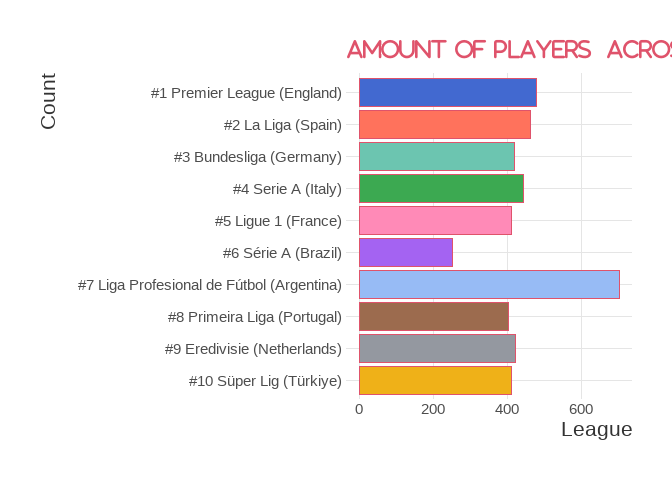

When looking at the player distribution across the top football leagues,
it’s clear that most leagues have a similar number of players, usually
between **400 and 500**. However, there are noticeable differences,
especially in the **Argentine** and **Brazilian** leagues.

The **Argentine Primera División** has **28 clubs**, which is more than
the usual **20 clubs** found in most top leagues. This larger number of
teams naturally leads to a higher total number of registered players.

In contrast, the **Campeonato Brasileiro Série A** has **20 clubs**,
similar to many major European leagues.Even with the same number of
clubs, differences in **player registration rules** and **squad
management** can cause variations in the total number of players across
leagues.

### Graph 2. Overall Score and Age Distribution Across Top Football Leagues

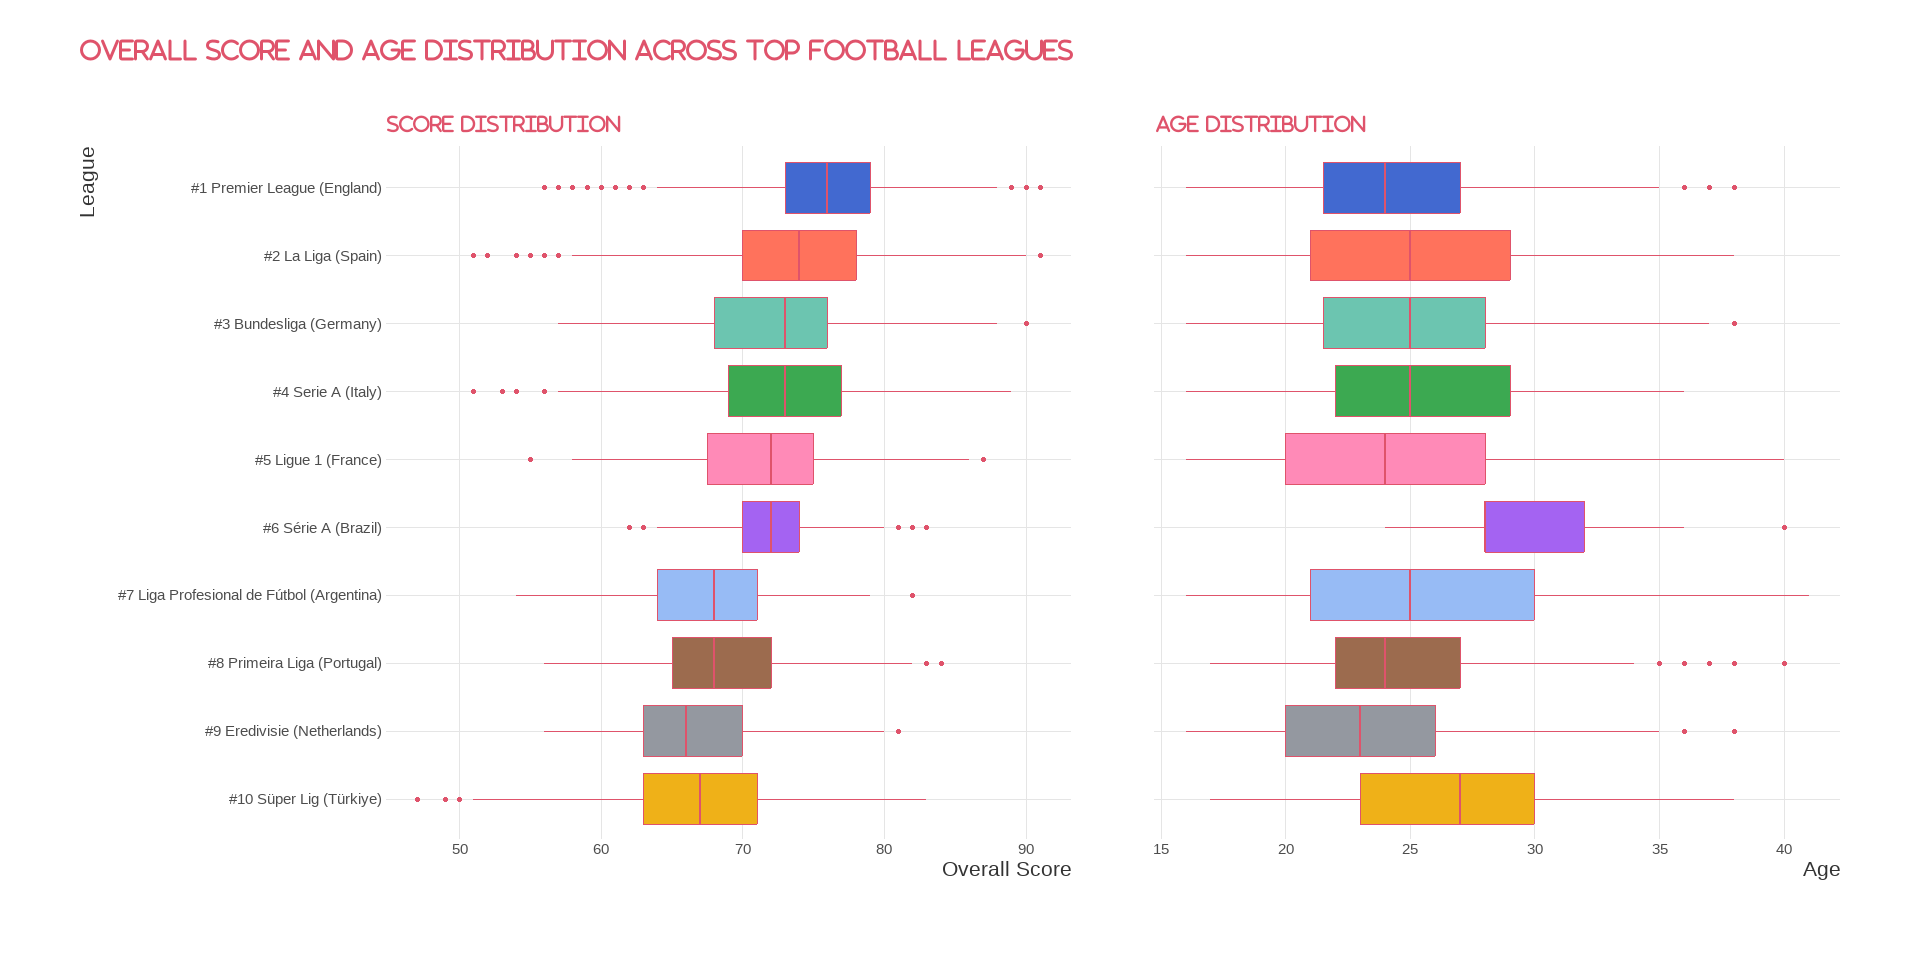

The **score distribution** reflects the **league rankings**, with top
leagues like the **Premier League**, **La Liga**, and **Bundesliga**
having players with **higher average scores**, showing that the best
talent is often found in these leagues. On the other hand, lower-ranked
leagues have a **wider range of scores**, meaning there’s more variety
in player performance.

The **age distribution** also shows that **top leagues are focused on
signing young, talented players**, as they have **younger average ages**
compared to other leagues. This suggests that top leagues are always on
the lookout for the next generation of football stars to stay
competitive.

### Graph 3. Player Performance Distribution Across Top Football Leagues

This graph shows the distribution of football players based on their
**Overall Score** (*x-axis*) and **Potential Score** (*y-axis*) across
the top 10 football leagues.

Players are categorized into four **performance groups**, defined using
the **median Overall Score** and **median Potential Score**, calculated
across all players:

-   **🟢 Emerging High Performers (light green):**  
    Players with **high current performance and high potential**,
    positioned **above both medians**.

-   **🟢 Future High Performers (dark green):**  
    Players with **lower current performance but high potential**,
    falling **below the median for Overall Score** but **above the
    median for Potential Score**.

-   **⚫ High Peak Performers (gray):**  
    Players with **high current performance but limited growth
    potential**, identified as having an **Overall Score above the
    median** but **Potential Score below the median**.

-   **🔴 Limited Performance (red):**  
    Players with **low current performance and low potential**,
    positioned **below both medians**.

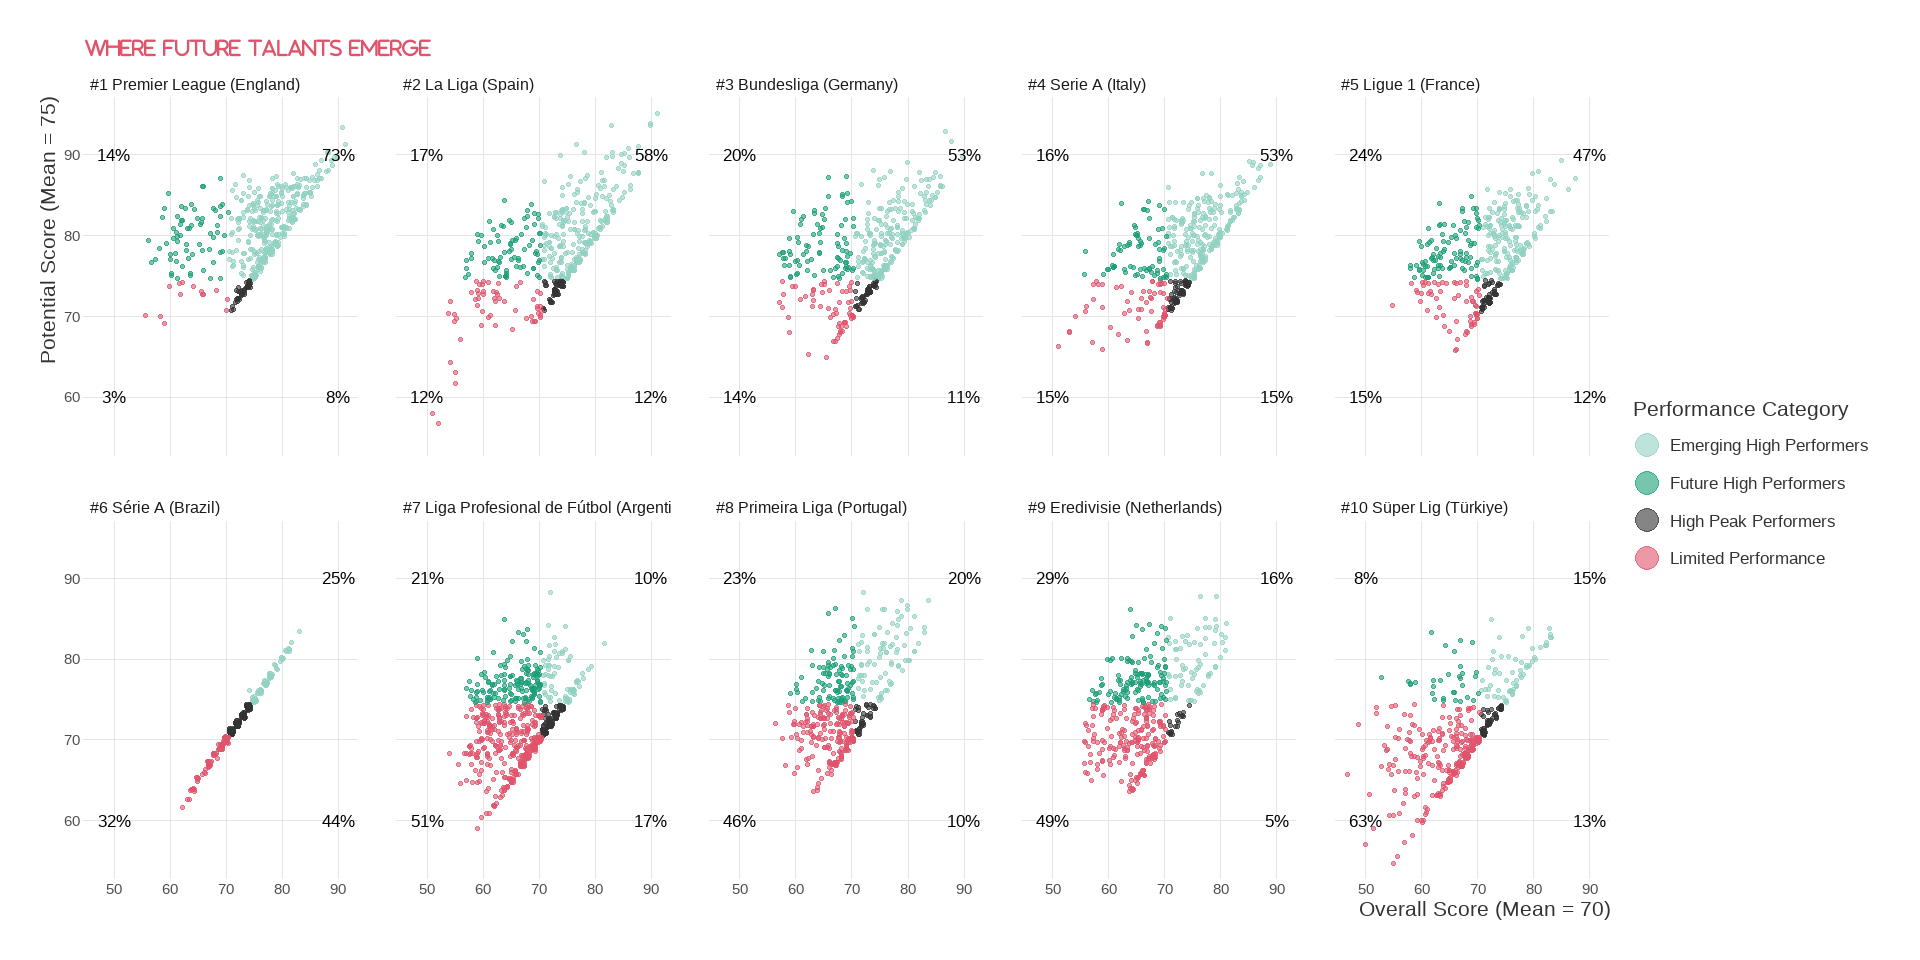

Top European leagues like the **Premier League (England)**, **La Liga
(Spain)**, and **Bundesliga (Germany)** have a **higher percentage of
Emerging High Performers** attract players who are already performing at
a high level while still having room for growth.

In contrast, leagues such as the **Süper Lig (Turkey)** and **Liga
Profesional de Fútbol (Argentina)** show a **higher concentration of
Limited Performance players** (**63%** and **51%**, respectively).

Leagues like the **Eredivisie (Netherlands)** and **Primeira Liga
(Portugal)** stand out for their **strong representation of Future High
Performers** (**29%** and **23%**). These leagues are well-known for
**developing young talents** who often move on to larger clubs in
top-tier competitions.

Meanwhile, leagues such as **Serie A (Italy)** and **Ligue 1 (France)**
display a **more balanced distribution** across all performance
categories. This reflects a healthy mix of **Veteran stars**, **Future
talents**, and **Squad players**.

### Graph 4. Contract Duration vs Overall Score Across Top Football Leagues

This graph illustrates the relationship between players’ Overall Score
(x-axis) and their Contract Duration in years (y-axis) across the top 10
football leagues. Each black dot represents an individual player, while
the red line indicates the trend line (linear regression), showing the
general direction of the relationship.

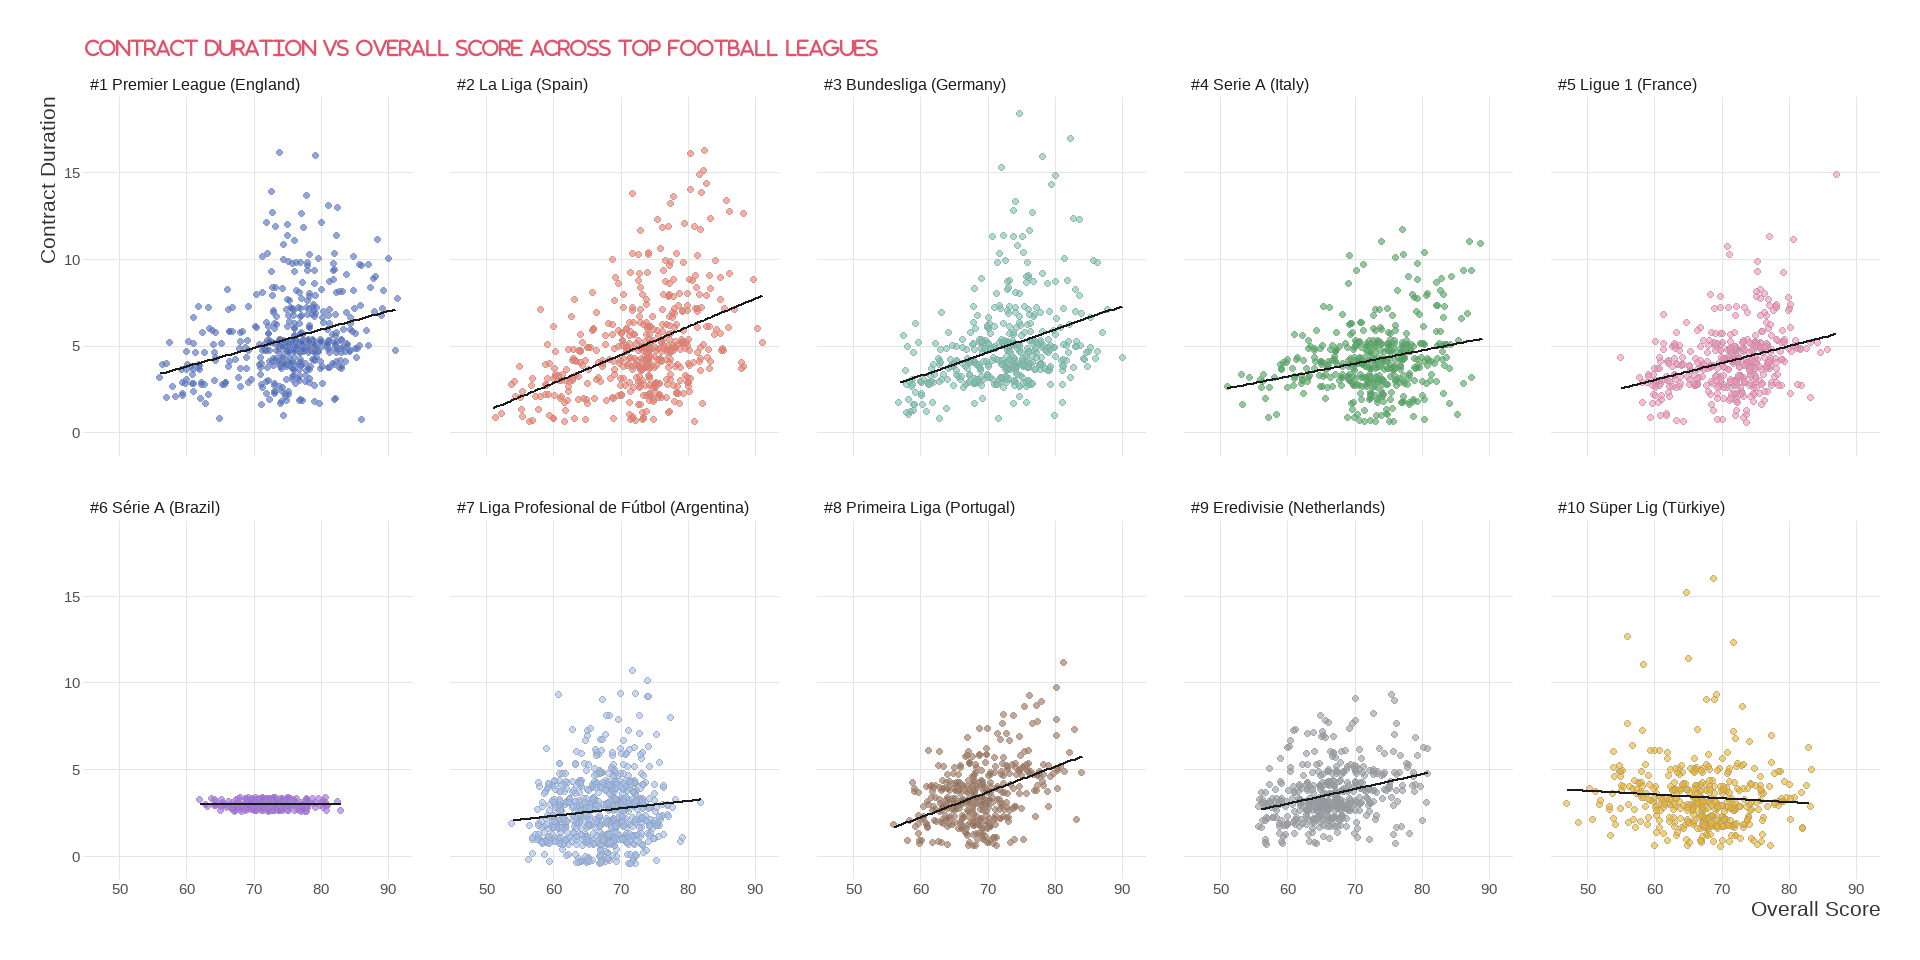

While there’s a general trend of longer contracts for higher-rated
players, the strength of this relationship varies by league. Top leagues
seem to reward talent with longer commitments, while others may have
less flexibility due to financial or structural factors.

### Graph 5. Wage Distribution Across Top Football Leagues

Have you ever been curious about how much football players earn?

This graph shows the average weekly salary (in thousands of euros) for
players in the top 10 football leagues.

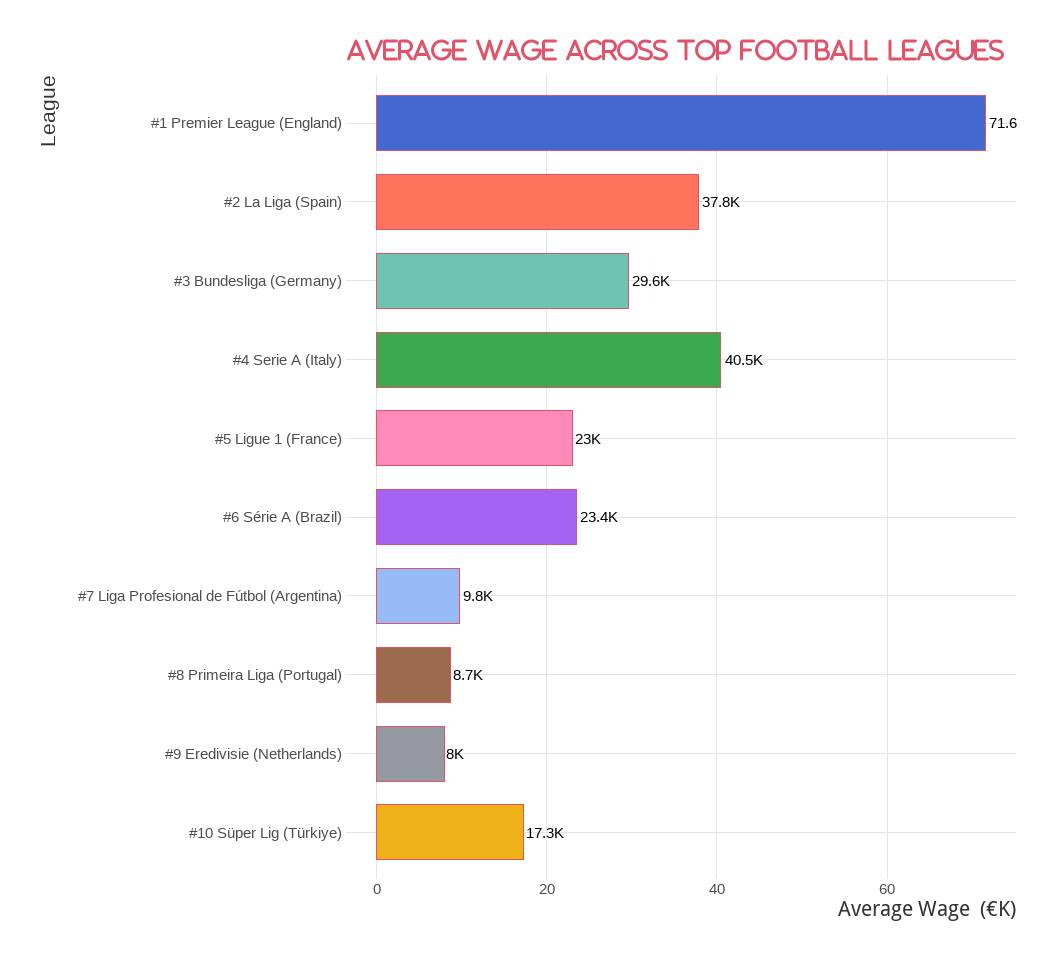

The **Premier League (England)** leads with **€71.6K**, nearly
**double** that of the next two highest-paying leagues—**Serie A
(Italy)** at **€40.5K** and **La Liga (Spain)** at **€37.8K**.

Compared to leagues like the **Eredivisie (Netherlands)** (**€8K**) and
**Primeira Liga (Portugal)** (**€8.7K**), Premier League players earn
almost **9 times more**.

Interestingly, the **Seria A(Brazil)** and **Süper Lig (Turkey)** show
relatively **high average wages** compared to leagues with similar
competitive levels.

### Graph 6. Wage Distribution by Role

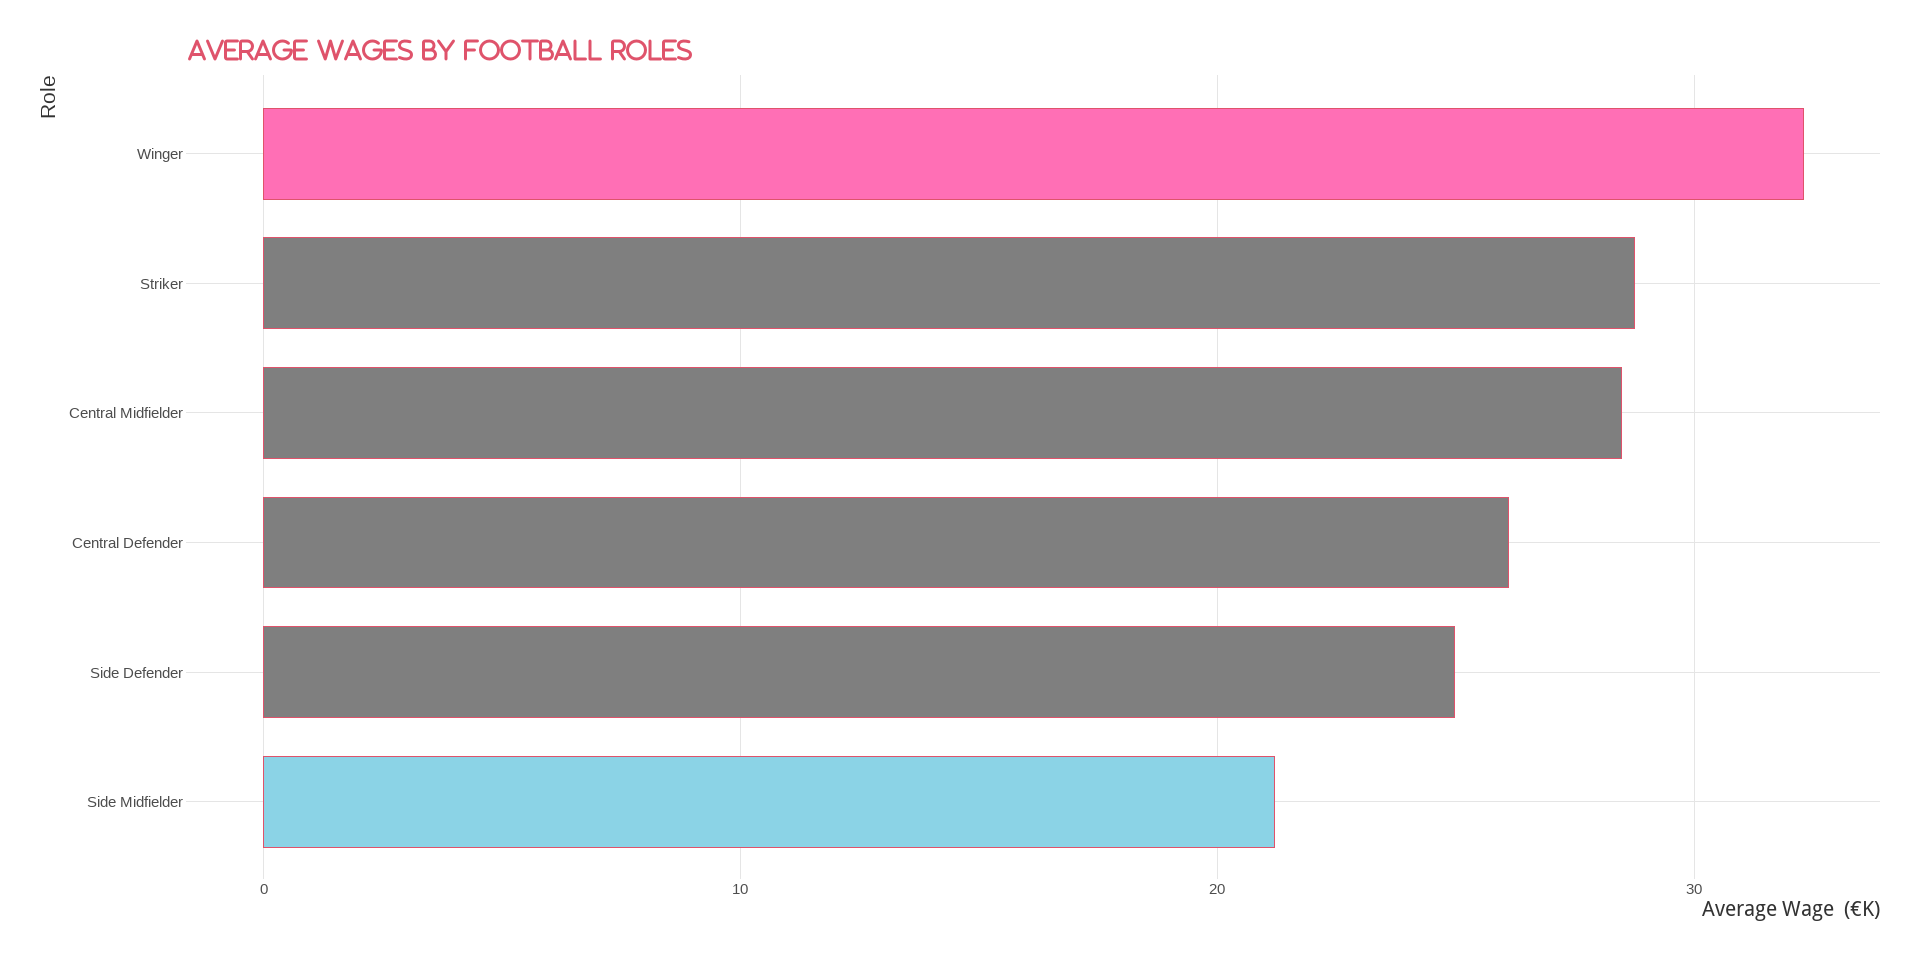

Wingers (pink) earn the most, likely due to their game-changing impact
in attack.

Side Midfielders (light blue) earn the least, as their role is often
less decisive in scoring or defense.

Strikers, Midfielders, and Defenders fall in between, reflecting their
varying influence on the game.

### Graph 7. Salary Trends and Tactical Priorities Across Leagues

Let’s combine the last two charts to see if Wingers consistently earn
the most and Side Midfielders the least across all leagues.

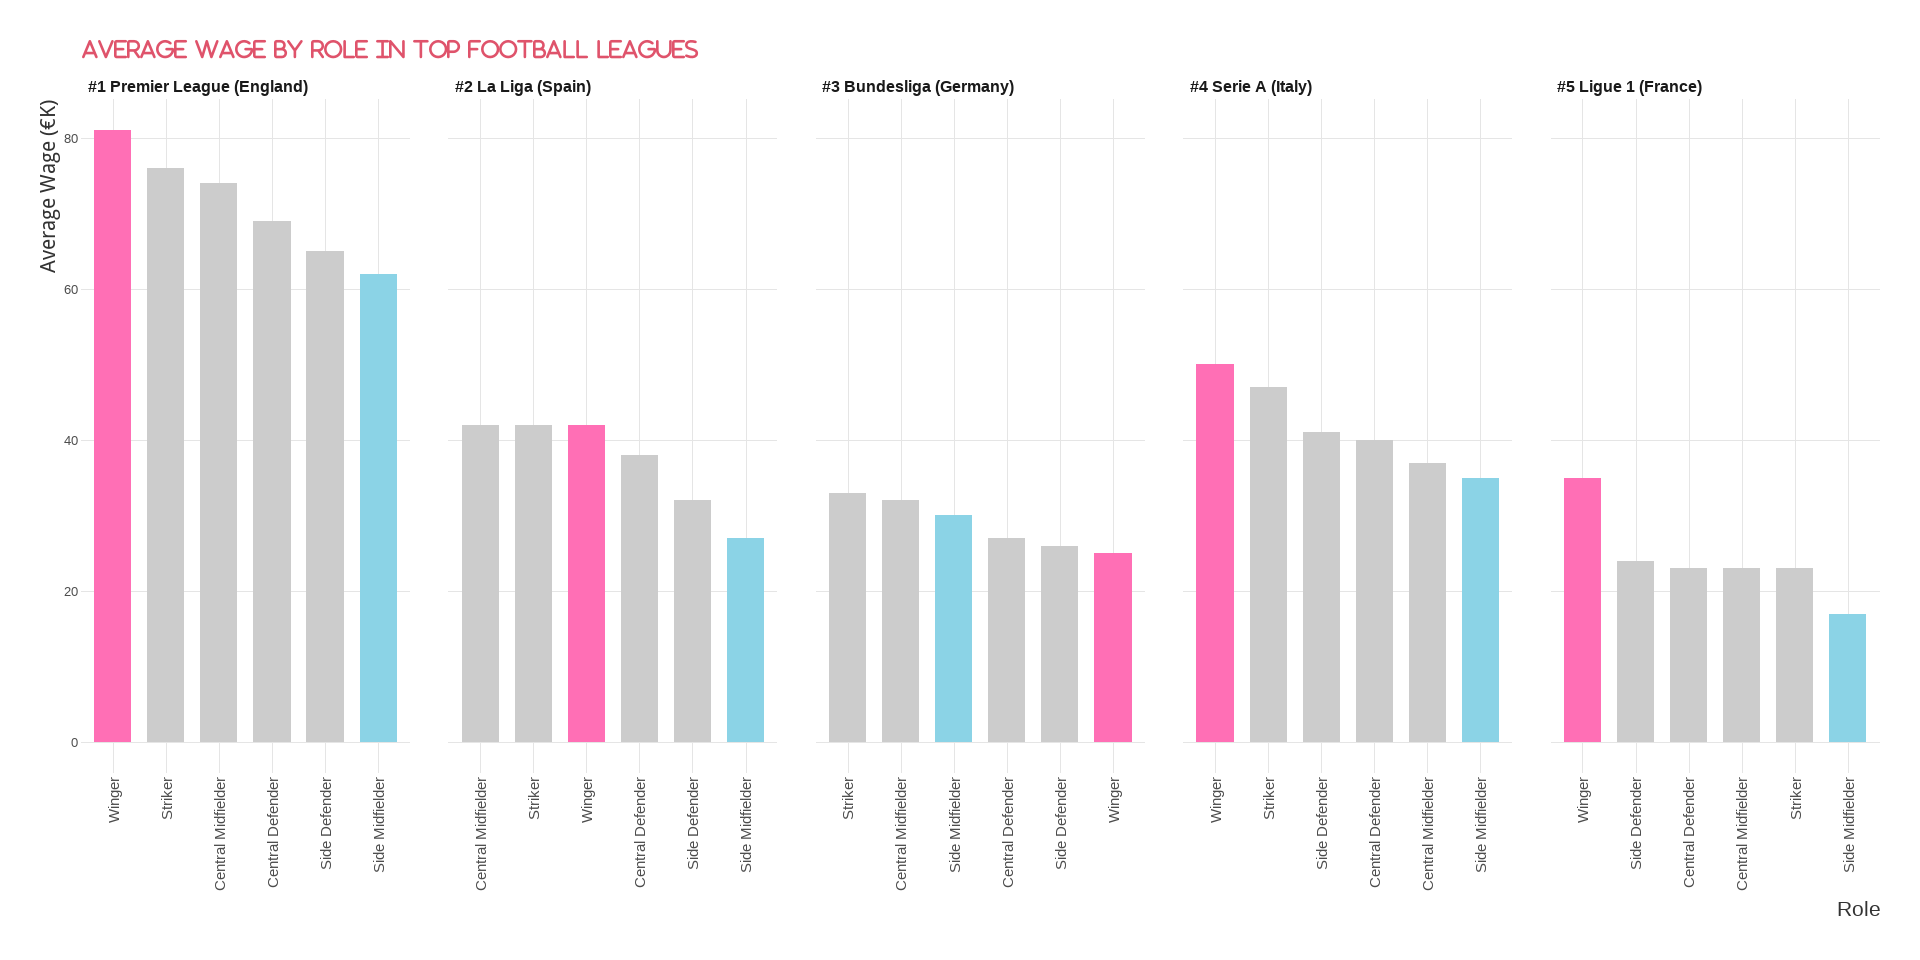

Salary trends reflect not only player performance but also the
**tactical priorities** of each league. **Wingers** are highly valued in
leagues that emphasize fast, attacking football, such as the **Premier
League**, while leagues like **La Liga** tend to reward **goal-scoring
central roles**.

Despite these differences, **side midfielders consistently receive the
lowest wages** across all leagues, highlighting a trend where their
contributions are less financially recognized.

Interestingly, the **Bundesliga** stands out with a more **balanced wage
distribution**, suggesting a strategic focus on **team-oriented play**
rather than heavy reliance on specific star positions.

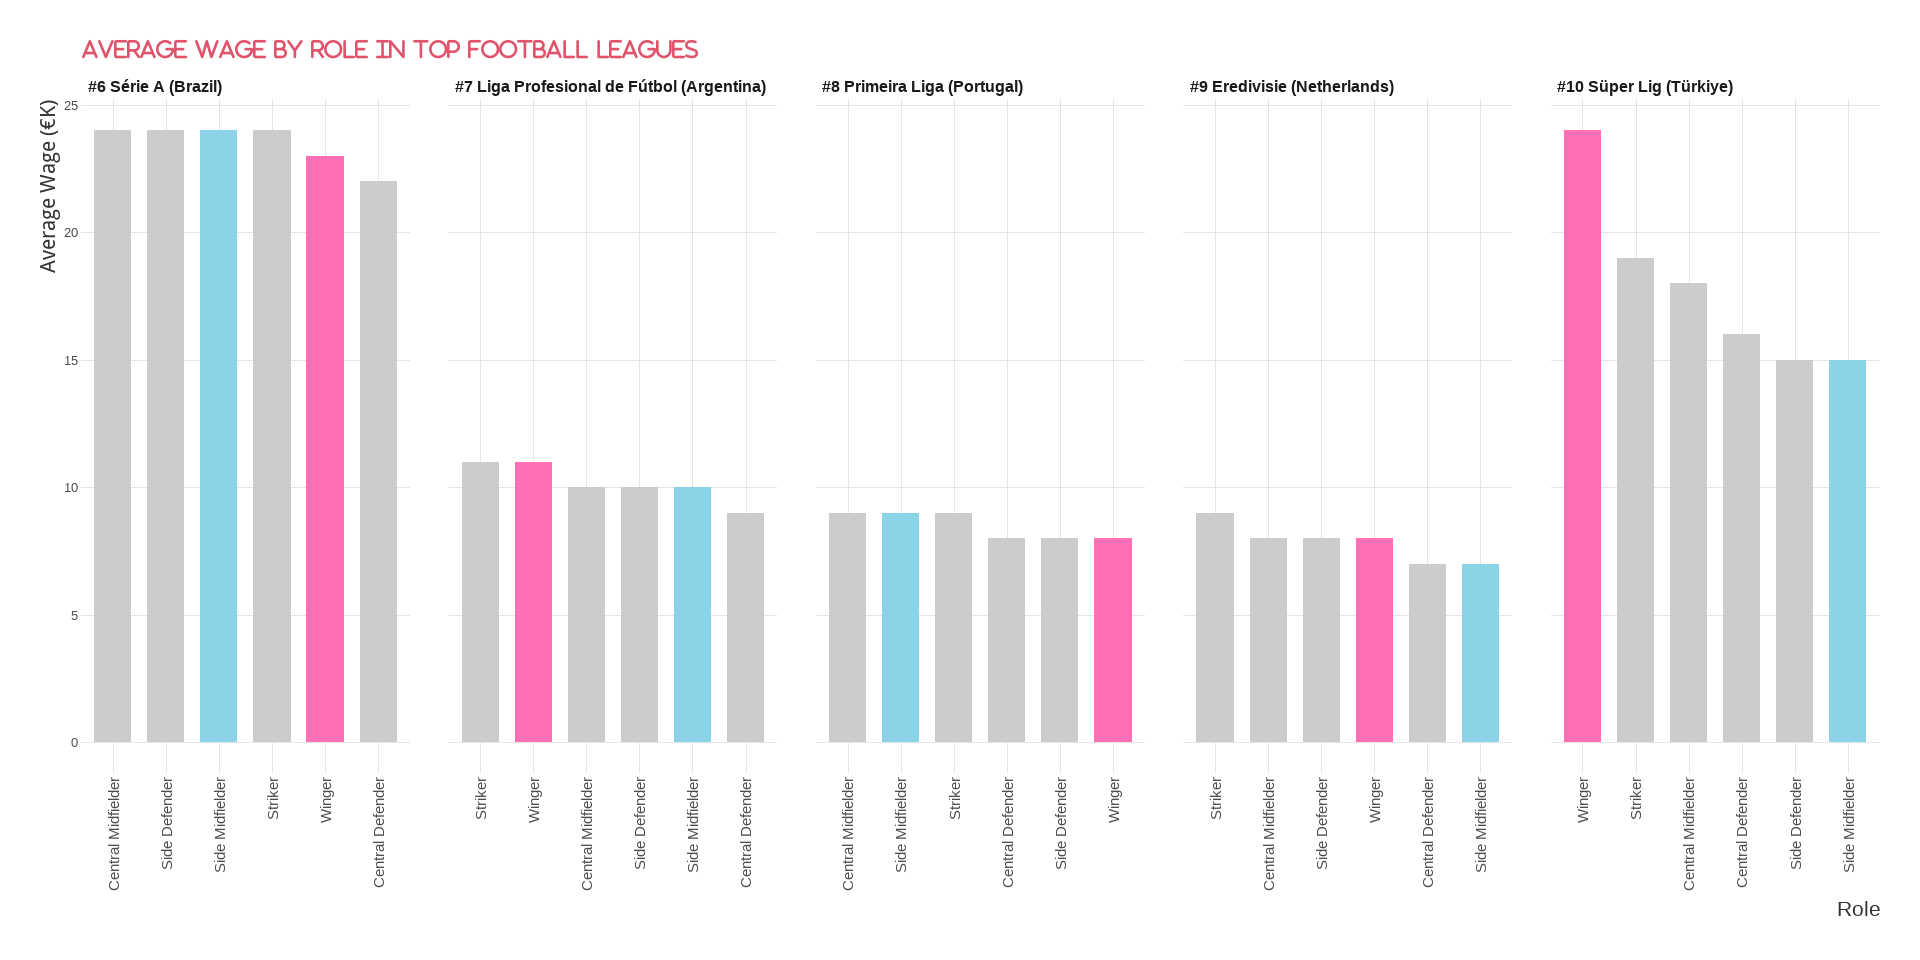

Compared to the top 5 European leagues, only the **Süper Lig (Turkey)**
shows a similar pattern, with **wingers** earning the most and **side
midfielders** the least. **Argentina’s Liga Profesional** has a
**balanced wage distribution**, much like the **Bundesliga**, reflecting
a focus on **team-wide value** rather than specific roles.

In **Brazil’s Série A**, **defensive roles** earn wages comparable to
attackers, highlighting the **importance of defensive contributions**.

Meanwhile, both **Portugal’s Primeira Liga** and the **Netherlands’
Eredivisie** show **lower, more balanced wages**, which aligns with
their emphasis on **youth development** and maintaining **financial
sustainability** within clubs.

## Multi-Linear Regression Models

Lets run Multi-Linear Regression Models for the top 5 leagues to
understand how different player performance metrics and characteristics
influence their wages.

### Prepere Data for OLS

To prepare the data for OLS regression, I created dummy variables for
player roles, converted wages to thousands of Euros, and removed
unnecessary columns and missing data. I also removed highly correlated
variables to avoid multicollinearity, keeping the dataset clean for
analysis.

In [ ]:
df_ols <- df_clean %>%
  mutate(
    Winger = ifelse(Role == "Winger", 1, 0),
    Striker = ifelse(Role == "Striker", 1, 0),
    Central_Midfielder = ifelse(Role == "Central Midfielder", 1, 0),
    Central_Defender = ifelse(Role == "Central Defender", 1, 0),
    Side_Defender = ifelse(Role == "Side Defender", 1, 0),
    Wage = Wage / 1000
  ) %>%
    select(
    -c(Player, LeagueRanked, `Performance Category`, Role, Total_Count,Count,Percentage,x_pos,y_pos,Growth,Base.Stats,Weight_kg,League_Rank,Height_cm                  ,Jumping,Heading.Accuracy ,Sliding.tackle,Left_Foot,Contract.Duration,Penalties )) %>%
  drop_na()


colnames(df_ols)

 [1] "League"                   "Age"                     
 [3] "Overall.Score"            "Potential.Score"         
 [5] "Value"                    "Wage"                    
 [7] "Crossing"                 "Finishing"               
 [9] "Short.Passing"            "Volleys"                 
[11] "Dribbling"                "Curve"                   
[13] "FK.Accuracy"              "Long.Passing"            
[15] "Ball.Control"             "Acceleration"            
[17] "Sprint.Speed"             "Agility"                 
[19] "Reactions"                "Balance"                 
[21] "Shot.Power"               "Stamina"                 
[23] "Strength"                 "Long.Shots"              
[25] "Aggression"               "Interceptions"           
[27] "Attack.Position"          "Vision"                  
[29] "Composure"                "Defensive.Awareness"     
[31] "Standing.Tackle"          "Skill.Moves"             
[33] "International.Reputation" "Pace.Diving"           

In the next code snippet, I run an Ordinary Least Squares (OLS)
regression. Before that, I apply the Recursive Feature Elimination (RFE)
method to select the top 18 most important variables that influence
player wages. This method helps reduce dimensionality and improve model
performance by iteratively removing less significant features. After
fitting the initial regression model, I keep only the variables that are
statistically significant (p-value \< 0.05). This process resembles
backward elimination because it systematically removes insignificant
variables, although the primary selection is done through RFE.

In [ ]:
#install.packages("caret")
#install.packages("MASS")
library(MASS) 
library(caret)
library(dplyr)

run_RFE <- function(league_name, corr_threshold = 0.75, p_value_threshold = 0.05) {

  data_league <- df_ols %>% filter(League == league_name) %>% dplyr::select(-"League")
  X_filtered <- data_league %>% dplyr::select(-c("Wage"))
  y <- data_league$Wage

  corr_matrix <- cor(X_filtered, use = "pairwise.complete.obs")
  high_corr_vars <- findCorrelation(corr_matrix, cutoff = corr_threshold, names = TRUE, exact = TRUE)
  X_filtered <- X_filtered %>% dplyr::select(-all_of(high_corr_vars))
  
  control <- rfeControl(functions = lmFuncs, method = "cv", number = 10)
  rfe_model <- rfe(X_filtered, y, sizes = 18, rfeControl = control)
  best_vars <- predictors(rfe_model)
  
  data_league <- data_league %>% dplyr::select(Wage, Value, all_of(best_vars))
  final_formula <-as.formula(paste("Wage~", paste(best_vars,collapse=" + ")))
  final_model <- lm(final_formula, data = data_league)
  model_summary<-summary(final_model)
    
  significant_vars <- names(which(model_summary$coefficients[, 4] < p_value_threshold))
  significant_vars <- significant_vars[significant_vars != "(Intercept)"]  
  
  if (length(significant_vars) > 0) {
    final_model <- lm(as.formula(paste("Wage ~", paste(significant_vars, collapse = " + "))), 
                      data = data_league)
    model_summary <- summary(final_model)
  } 

  return(list(data_league=data_league, model_summary=model_summary))
}

# Apply to each league
results_England <- run_RFE("Premier League (England)")
results_Germany <- run_RFE("Bundesliga (Germany)")
results_Italy   <- run_RFE("Serie A (Italy)")
results_Spain   <- run_RFE("La Liga (Spain)")
results_France  <- run_RFE("Ligue 1 (France)")

### MLR for Premier League (England)

In [ ]:
print(results_England$model_summary)


Call:
lm(formula = as.formula(paste("Wage ~", paste(significant_vars, 
    collapse = " + "))), data = data_league)

Residuals:
    Min      1Q  Median      3Q     Max 
-77.910 -11.622  -0.269  10.114 214.479 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -303.9230    36.7885  -8.261 1.64e-15 ***
International.Reputation   28.1454     1.6931  16.624  < 2e-16 ***
Potential.Score             2.4703     0.4835   5.109 4.80e-07 ***
Age                         1.2911     0.4981   2.592  0.00985 ** 
Reactions                   1.3738     0.2596   5.292 1.90e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 23.33 on 448 degrees of freedom
Multiple R-squared:  0.7843,    Adjusted R-squared:  0.7823 
F-statistic: 407.2 on 4 and 448 DF,  p-value: < 2.2e-16

### MLR for La Liga (Spain)

In [ ]:
print(results_Spain$model_summary)


Call:
lm(formula = as.formula(paste("Wage ~", paste(significant_vars, 
    collapse = " + "))), data = data_league)

Residuals:
    Min      1Q  Median      3Q     Max 
-99.803  -7.425  -0.367   7.479 207.139 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -4.226e+01  9.130e+00  -4.629 4.84e-06 ***
International.Reputation  3.249e+01  1.936e+00  16.779  < 2e-16 ***
Sprint.Speed              3.864e-01  1.310e-01   2.949  0.00335 ** 
Value                     1.217e-06  1.098e-07  11.086  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 30.01 on 442 degrees of freedom
Multiple R-squared:  0.6351,    Adjusted R-squared:  0.6327 
F-statistic: 256.5 on 3 and 442 DF,  p-value: < 2.2e-16

### MLR for Bundesliga (Germany)

In [ ]:
print(results_Germany$model_summary)


Call:
lm(formula = as.formula(paste("Wage ~", paste(significant_vars, 
    collapse = " + "))), data = data_league)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.400  -4.258  -0.017   4.033  54.081 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -113.2829    14.4047  -7.864 3.54e-14 ***
International.Reputation   18.7617     1.0282  18.246  < 2e-16 ***
Potential.Score             0.9856     0.1919   5.137 4.39e-07 ***
Age                         0.5083     0.2264   2.245 0.025307 *  
Reactions                   0.3921     0.1124   3.487 0.000542 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.836 on 397 degrees of freedom
Multiple R-squared:  0.7925,    Adjusted R-squared:  0.7904 
F-statistic: 379.1 on 4 and 397 DF,  p-value: < 2.2e-16

### MLR for Serie A (Italy)

In [ ]:
print(results_Italy$model_summary)


Call:
lm(formula = as.formula(paste("Wage ~", paste(significant_vars, 
    collapse = " + "))), data = data_league)

Residuals:
    Min      1Q  Median      3Q     Max 
-88.399 -13.715  -2.936  12.589  73.608 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -227.7469    19.6442 -11.594  < 2e-16 ***
International.Reputation   19.7903     1.8280  10.826  < 2e-16 ***
Reactions                   1.2623     0.1845   6.843 2.74e-11 ***
Potential.Score             1.6684     0.2847   5.860 9.36e-09 ***
Pace.Diving                 0.3249     0.1023   3.176   0.0016 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.89 on 422 degrees of freedom
Multiple R-squared:  0.6259,    Adjusted R-squared:  0.6223 
F-statistic: 176.5 on 4 and 422 DF,  p-value: < 2.2e-16

### MLR for Ligue 1 (France)

In [ ]:
print(results_France$model_summary)


Call:
lm(formula = as.formula(paste("Wage ~", paste(significant_vars, 
    collapse = " + "))), data = data_league)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.705  -5.292  -0.511   3.888  57.091 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -9.202e+01  9.563e+00  -9.622  < 2e-16 ***
International.Reputation  1.766e+01  1.046e+00  16.874  < 2e-16 ***
Winger                    4.991e+00  2.276e+00   2.193 0.028876 *  
Central_Defender          9.896e-01  1.237e+00   0.800 0.424059    
Potential.Score           4.819e-01  1.331e-01   3.621 0.000332 ***
Reactions                 6.361e-01  7.810e-02   8.144 5.33e-15 ***
Sprint.Speed              1.588e-01  4.635e-02   3.427 0.000676 ***
Value                     3.846e-07  7.850e-08   4.899 1.42e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.783 on 386 degrees of freedom
Multiple R-squared:  0.7294,    Adjus

The OLS regression results across the top 5 European leagues reveal that
International Reputation is the strongest and most consistent factor
influencing player wages. However, this likely reflects a two-way
relationship, where playing in top leagues boosts a player’s
international reputation, which in turn is linked to higher wages.

Potential Score and Reactions also play significant roles, indicating
the importance of both future growth potential and on-field
responsiveness.